<a href="https://colab.research.google.com/github/AkindeKadjo/Customer_finance_clustoring/blob/main/02_Analysis_of_KMeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Name: Akinde Kadjo

Date: 10/10/2022

** We are interested in grouping our customers into groups based on similar characteristics. This can help the company effectively allocate marketing resources. We will use customer age, education, years of employment, income, debt, whether they defaulted, and their debt to income ratio to group them into segments.**

The original data is from this data [source](https://github.com/Nikhil-Adithyan/Customer-Segmentation-with-K-Means).



In [1]:
#Importing all of the libraries that may be needed for the project
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
#Loading the data
filename = '/content/drive/MyDrive/Coding Dojo/09 Week 9 Unsupervised ML/cust_seg.csv'
Original_df = pd.read_csv(filename)
# keeping a copy of the df as a safety net
df = Original_df.copy()
df.head()

,Unnamed: 0,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
0,0,1,41,2,6,19,0.124,1.073,0.0,6.3
1,1,2,47,1,26,100,4.582,8.218,0.0,12.8
2,2,3,33,2,10,57,6.111,5.802,1.0,20.9
3,3,4,29,2,4,19,0.681,0.516,0.0,6.3
4,4,5,47,1,31,253,9.308,8.908,0.0,7.2


#Data Cleaning

In [3]:
#checking for data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       850 non-null    int64  
 1   Customer Id      850 non-null    int64  
 2   Age              850 non-null    int64  
 3   Edu              850 non-null    int64  
 4   Years Employed   850 non-null    int64  
 5   Income           850 non-null    int64  
 6   Card Debt        850 non-null    float64
 7   Other Debt       850 non-null    float64
 8   Defaulted        700 non-null    float64
 9   DebtIncomeRatio  850 non-null    float64
dtypes: float64(4), int64(6)
memory usage: 66.5 KB


In [4]:
# how many data points are duplicated?
df.duplicated().sum()

0

In [5]:
#deleting the unamed column, it is just a replicate of the index and Customer Id
df.drop(columns=['Unnamed: 0', 'Customer Id'],inplace=True)

In [6]:
#check for missing values
df.isna().sum()

Age                  0
Edu                  0
Years Employed       0
Income               0
Card Debt            0
Other Debt           0
Defaulted          150
DebtIncomeRatio      0
dtype: int64

In [7]:
#percentage of rows with missing data
((df.isnull().any(axis=1).sum())/len(df)*100).round(2)

17.65

>The cell above shows that there are indeed missing values. These missing values are less than 20% of our data set, so I'll decide to drop these row. Deleting the 'Defaulted' column may cause us to loose some valuable informations, while using a simple imputer to replace those values may bias our results. So I'll opt for deleting the rows with missing values.

In [8]:
df.dropna(inplace=True)
df.isna().sum()

Age                0
Edu                0
Years Employed     0
Income             0
Card Debt          0
Other Debt         0
Defaulted          0
DebtIncomeRatio    0
dtype: int64

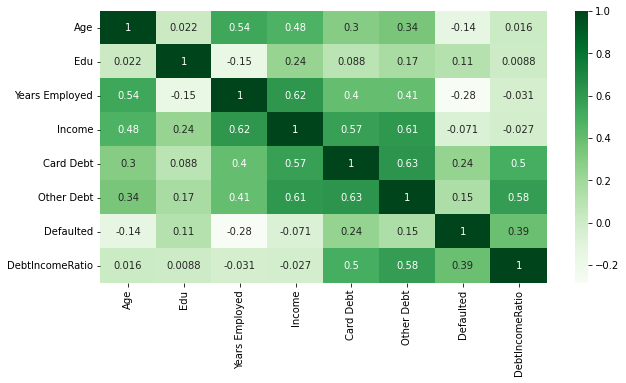

In [9]:
#A quick overview of how each feature relate to one another
corr = df.corr()
fig, ax = plt.subplots(figsize=(10,5)) 
sns.heatmap(corr, cmap = 'Greens', annot =True);

#1)Use KMeans to create various customer segments

##1.Use an Elbow Plot of inertia

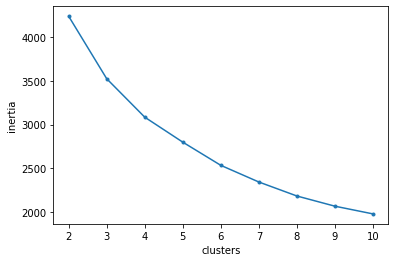

In [10]:
# Instantiate Standard Scaler
scaler = StandardScaler()
# Fit & transform data.
scaled_df = scaler.fit_transform(df)
#Create an empty list of inertias
inertias = []
#Loop through k values between 2 and 10 and store the inertias in the list.
for k in range(2,11):
    kmeans = KMeans(n_clusters=k)  
    kmeans.fit(scaled_df)  
    inertias.append(kmeans.inertia_)
#Visualize scores
plt.plot(range(2,11), inertias, marker = '.')
plt.xlabel('clusters')
plt.ylabel('inertia');

>The Elbow happens at 3 , which means 3 is a good number of clusters

##2.A plot of Silhouette Scores

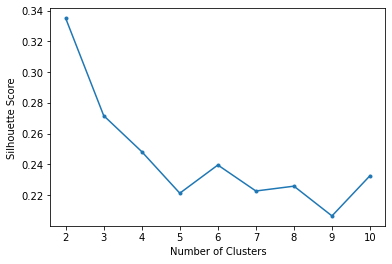

In [11]:
# Visualize different silhouette scores
# Save silhouette scores for various cluster numbers in list
silhouette_scores = []
for i in range(2, 11):
  kmeans = KMeans(n_clusters = i)
  kmeans.fit(scaled_df)
  silhouette_scores.append(silhouette_score(scaled_df, kmeans.labels_))
# Visualize scores
plt.plot(range(2, 11), silhouette_scores, marker = '.')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score');

>The Silhouette score implies that the best number of clusters is 2

##3.Choose a K based on the results

> I will go for a K value of 3. Based on the type of Data being analyzed it seems as though 3 groups being targetted makes more sense: those likely to be financialy stable, those that are not and those that find themselves in the middle.

In [17]:
# Refit KMeans with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(scaled_df)
# Add the clusters as a column in the dataframe
df['cluster'] = kmeans.labels_
df.head()

,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio,cluster
0,41,2,6,19,0.124,1.073,0.0,6.3,1
1,47,1,26,100,4.582,8.218,0.0,12.8,0
2,33,2,10,57,6.111,5.802,1.0,20.9,2
3,29,2,4,19,0.681,0.516,0.0,6.3,1
4,47,1,31,253,9.308,8.908,0.0,7.2,0


In [18]:
# Group the dataframe by cluster and aggregate by mean values
# Add as_index=False so that the clusters are a column, not the index
cluster_groups = df.groupby('cluster', as_index=False).mean()
cluster_groups

,cluster,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
0,0,43.112000,1.960000,16.904000,96.056000,4.172896,7.811616,0.208000,14.398400
1,1,33.727053,1.601449,7.644928,36.246377,0.788126,1.748710,0.000000,7.581884
2,2,31.366460,1.850932,3.689441,30.484472,1.488199,2.734901,0.975155,13.936025


#4.Visualizing and Analyzing the Clusters

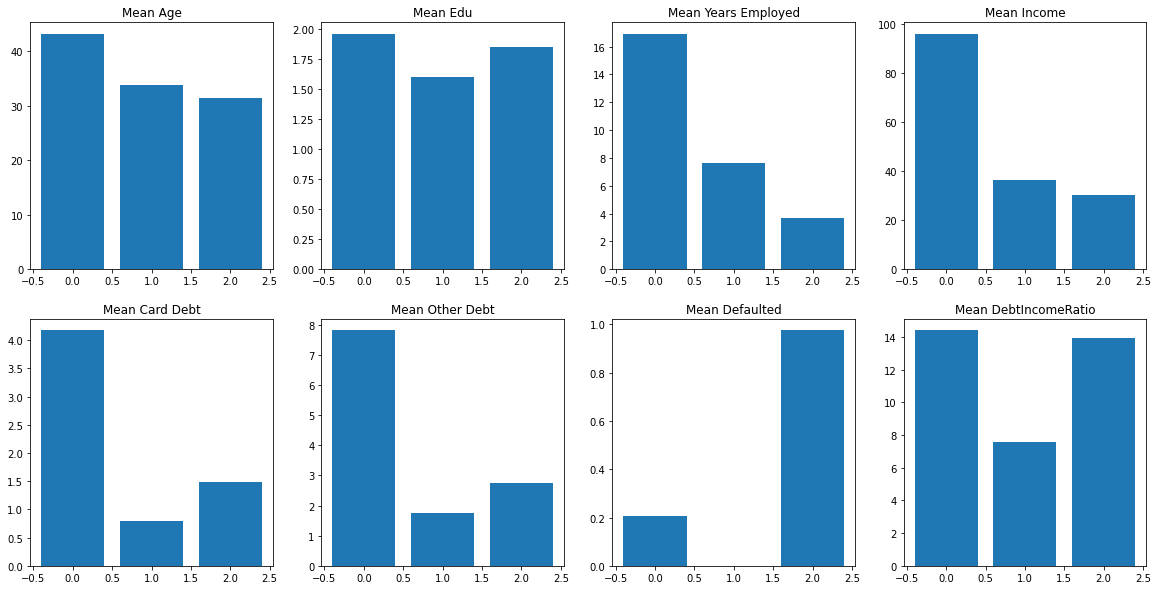

In [19]:
# Visualize means 
fig, axes = plt.subplots(2,4, figsize = (20, 10))
# fig is an array of dimensions 2,4.  axes.ravel() will flatten it to 8,1
axes = axes.ravel()
# Loop over columns and plot each in a separate figure, skip 'cluster' column
for i, col in enumerate(cluster_groups.columns[1:]):
  axes[i].bar(cluster_groups['cluster'], cluster_groups[col])
  axes[i].set_title(f'Mean {col}')

>Cluster 0: These custommers are a bit older (Average age of ~ 43), they are a lot more educated, have been employed the longest (17 years on average) and it therefore makes sense that they have a much higher Mean income. As we all know income tends to increase over time. Their both mean card debts and other debts are much higher, which seems not too alarming since they considerably have a much higher income and when comparing the Mean Debt income ratio their numbers are similar to those in cluster 2. And only 20% of them have defaulted. 


>Cluster 1:These custommers are slightly younger (Average age of ~ 33), they are the least educated, but not drastically lower. They have been employed the 2nd longest (8 years on average) and it is reflected in their Mean income. This is most financially savy group as they possess the lowest mean card debts, other debts and Mean Debt income ratio. To top it off none of them have defaulted. 

>Cluster 2:These custommers are the youngest (Average age of ~ 31), they are  educated, have been employed the least longer (4 years on average) and hence them having the lowest Mean income. Their both mean card debts and other debts are not so high at first sight, however their Mean Debt income ratio are similar to those of cluster 0. And what seems alarming is that 98% of them have defaulted. 

##Recommendations

>Cluster 0: Althgough these customers are high earners, they tend to spend a lot. They borrowing risk is not negligeable since 20% default. I'll recommend providing a credit limit relative to their income, with a high interest rate. 


>Cluster 1: This is most financially savy group, as none of them have defaulted. I'll recommend providing a credit limit relative to their income, with a low interest rate.

>Cluster 2:These custommers are not reliable.I'll recommend providing a  lower credit limit relative to their income, with a high interest rate.